### Linear Regression

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy import stats
import math

In [3]:
# --- Synthetic dataset (multi-feature, with mild heteroscedasticity ~ variance)
n = 300
X1 = np.random.uniform(-3, 3, size=n)
X2 = np.random.normal(0, 1, size=n)
X3 = np.random.uniform(-2, 2, size=n)

true_signal = 3.0*X1 - 2.0*X2 + 0.5*(X1*X3)
noise_sigma = 0.6 + 0.2*np.abs(X1)
eps = np.random.normal(0, noise_sigma)
y = true_signal + eps
X = np.column_stack([X1, X2, X3])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
x1_train, x1_test = X_train[:, 0], X_test[:, 0]


In [4]:
# --- Models ---
multi_lr = LinearRegression()
multi_lr.fit(X_train, y_train)

lr_1d = LinearRegression()
lr_1d.fit(x1_train.reshape(-1,1), y_train)

# --- Grid & intervals for 1D OLS ---
x1_grid = np.linspace(x1_train.min(), x1_train.max(), 200)
y_hat_grid = lr_1d.predict(x1_grid.reshape(-1,1))

y_train_hat_1d = lr_1d.predict(x1_train.reshape(-1,1))
resid_1d = y_train - y_train_hat_1d
n_train = len(y_train)
xbar = x1_train.mean()
Sxx = np.sum((x1_train - xbar)**2)
SSE = np.sum(resid_1d**2)
s2 = SSE / (n_train - 2)
s = math.sqrt(s2)
alpha = 0.05
tcrit = stats.t.ppf(1 - alpha/2, df=n_train - 2)

def se_mean(x0):  # Standard error of predicted MEAN at x0
    return s * np.sqrt(1.0/n_train + ((x0 - xbar)**2) / Sxx)

def se_pred(x0):  # Standard error of a NEW prediction at x0
    return s * np.sqrt(1.0 + 1.0/n_train + ((x0 - xbar)**2) / Sxx)

SE_mean_grid = se_mean(x1_grid)
SE_pred_grid = se_pred(x1_grid)
ci_lower = y_hat_grid - tcrit * SE_mean_grid
ci_upper = y_hat_grid + tcrit * SE_mean_grid
pi_lower = y_hat_grid - tcrit * SE_pred_grid
pi_upper = y_hat_grid + tcrit * SE_pred_grid

def save_fig(fig, filename, title=None):
    if title:
        fig.suptitle(title)
    fig.tight_layout()
    path = os.path.join(out_dir, filename)
    fig.savefig(path, dpi=120)
    plt.show()
    return path

saved = []


Text(0.5, 1.0, 'Scatter with Fitted Line (1D)')

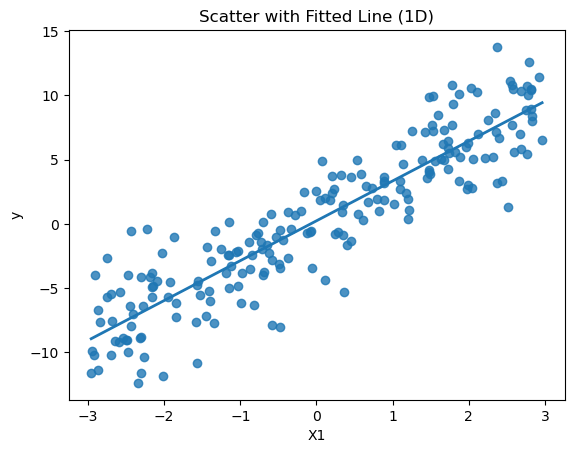

In [5]:
# ---------- 1) Scatter with Fitted Line (1D) ----------
"""
**Plot name:** Scatter with Fitted Line (1D)
- **X-axis:** X1 (single feature)
- **Y-axis:** Observed target y
- **When useful:** Visual check of linearity and basic fit quality.
- **Conditions/Caveats:** Only strictly interpretable in 1D.
"""
fig1, ax1 = plt.subplots()
ax1.scatter(x1_train, y_train, alpha=0.8)
ax1.plot(x1_grid, y_hat_grid, linewidth=2.0)
ax1.set_xlabel("X1")
ax1.set_ylabel("y")
ax1.set_title("Scatter with Fitted Line (1D)")



Text(0.05, 0.95, 'R² = 0.940')

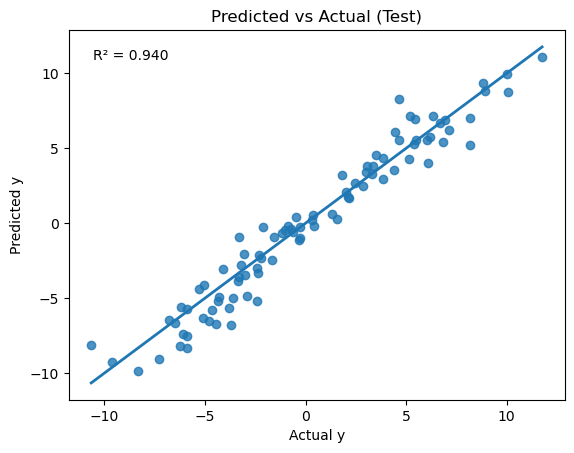

In [12]:
# ---------- 2) Predicted vs Actual (Test) ----------
"""
**Plot name:** Predicted vs Actual
- **X-axis:** Actual target values (y_true)
- **Y-axis:** Model predictions (y_pred)
- **When useful:** Compare predictions to truth; perfect model → 45° line.
- **Conditions/Caveats:** Keep axes min/max identical; annotate R².
"""
y_pred_test = multi_lr.predict(X_test)
fig2, ax2 = plt.subplots()
ax2.scatter(y_test, y_pred_test, alpha=0.8)
mn, mx = min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max())
ax2.plot([mn, mx], [mn, mx], linewidth=2.0)
ax2.set_xlabel("Actual y")
ax2.set_ylabel("Predicted y")
ax2.set_title("Predicted vs Actual (Test)")
r2 = r2_score(y_test, y_pred_test)
ax2.text(0.05, 0.95, f"R² = {r2:.3f}", transform=ax2.transAxes, va="top")


Text(0.5, 1.0, 'Confidence & Prediction Intervals (1D OLS)')

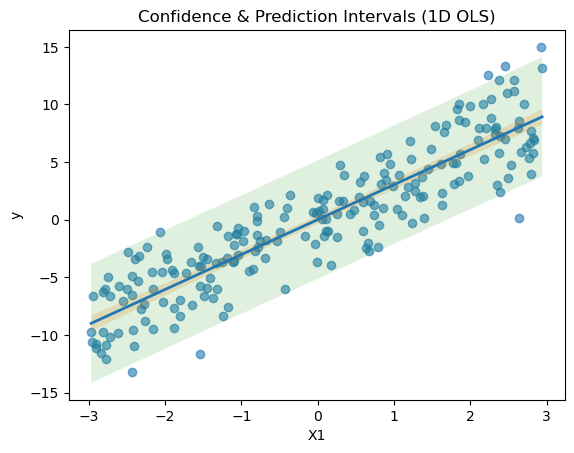

In [13]:

# ---------- 3) Confidence & Prediction Intervals (1D OLS) ----------
"""
**Plot name:** Confidence & Prediction Intervals (1D OLS)
- **X-axis:** X1 grid
- **Y-axis:** ŷ, CI for mean, PI for new observation
- **When useful:** Quantify uncertainty in mean response and future predictions.
- **Conditions/Caveats:** Exact under OLS assumptions; beware extrapolation.
"""
fig3, ax3 = plt.subplots()
ax3.scatter(x1_train, y_train, alpha=0.6)
ax3.plot(x1_grid, y_hat_grid, linewidth=2.0)
ax3.fill_between(x1_grid, ci_lower, ci_upper, alpha=0.2)
ax3.fill_between(x1_grid, pi_lower, pi_upper, alpha=0.15)
ax3.set_xlabel("X1")
ax3.set_ylabel("y")
ax3.set_title("Confidence & Prediction Intervals (1D OLS)")


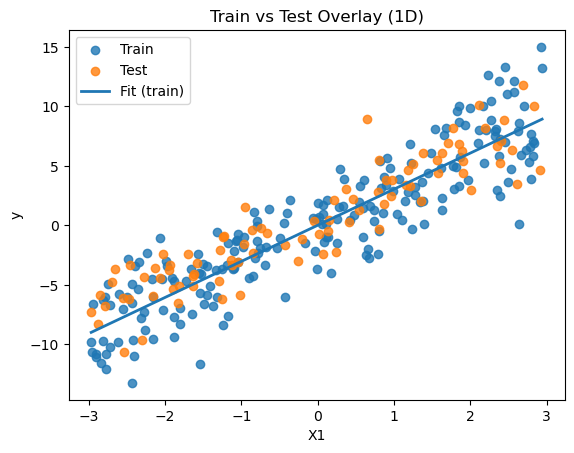

In [14]:

# ---------- 4) Train vs Test Overlay (1D) ----------
"""
**Plot name:** Train vs Test Overlay (1D)
- **X-axis:** X1 (train & test sets)
- **Y-axis:** Observed y
- **When useful:** Quick check of distribution shift and generalization.
- **Conditions/Caveats:** In high-D, prefer distribution plots or embeddings.
"""
fig4, ax4 = plt.subplots()
ax4.scatter(x1_train, y_train, alpha=0.8, label="Train")
ax4.scatter(x1_test,  y_test,  alpha=0.8, label="Test")
ax4.plot(x1_grid, y_hat_grid, linewidth=2.0, label="Fit (train)")
ax4.set_xlabel("X1")
ax4.set_ylabel("y")
ax4.set_title("Train vs Test Overlay (1D)")
ax4.legend()

Text(0.5, 1.0, 'Residuals vs Fitted (Test)')

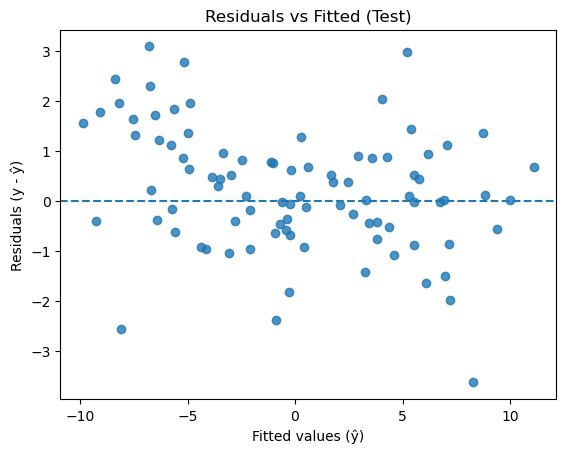

In [15]:
# ---------- 5) Residuals vs Fitted (Test) ----------
"""
**Plot name:** Residuals vs Fitted
- **X-axis:** Fitted values ŷ (test)
- **Y-axis:** Residuals (y - ŷ)
- **When useful:** Detect nonlinearity, heteroscedasticity, outliers.
- **Conditions/Caveats:** Random cloud around 0 is desired; funnels/curves indicate issues.
"""
resid_test = y_test - y_pred_test
fig5, ax5 = plt.subplots()
ax5.scatter(y_pred_test, resid_test, alpha=0.8)
ax5.axhline(0.0, linestyle="--", linewidth=1.5)
ax5.set_xlabel("Fitted values (ŷ)")
ax5.set_ylabel("Residuals (y - ŷ)")
ax5.set_title("Residuals vs Fitted (Test)")

Text(0.5, 1.0, 'Residual Histogram + KDE (Test)')

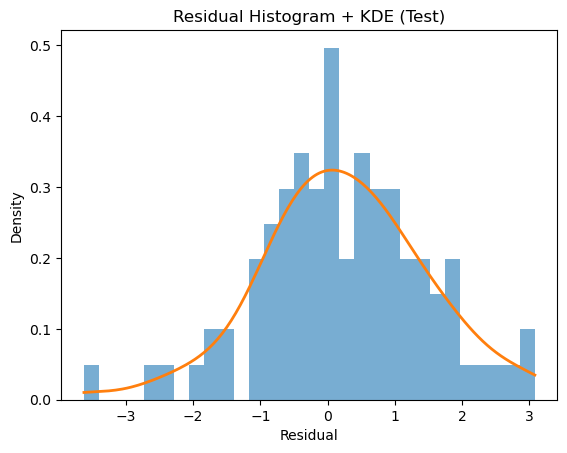

In [16]:
# ---------- 6) Residual Histogram + KDE (Test) ----------
"""
**Plot name:** Residual Histogram + KDE
- **X-axis:** Residual values
- **Y-axis:** Density
- **When useful:** Check normality assumption; detect skew/heavy tails.
- **Conditions/Caveats:** Consider log/Box-Cox transforms or robust loss if heavy-tailed.
"""
fig6, ax6 = plt.subplots()
ax6.hist(resid_test, bins=30, density=True, alpha=0.6)
kde = stats.gaussian_kde(resid_test)
grid = np.linspace(resid_test.min(), resid_test.max(), 200)
ax6.plot(grid, kde(grid), linewidth=2.0)
ax6.set_xlabel("Residual")
ax6.set_ylabel("Density")
ax6.set_title("Residual Histogram + KDE (Test)")

Text(0.5, 1.0, 'Q–Q Plot of Residuals (Test)')

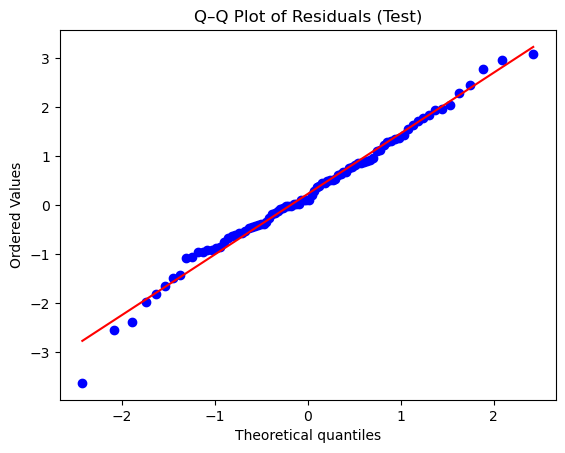

In [17]:
# ---------- 7) Q–Q Plot (Test) ----------
"""
**Plot name:** Q–Q Plot of Residuals
- **X-axis:** Theoretical quantiles (Normal)
- **Y-axis:** Ordered sample quantiles of residuals
- **When useful:** Visual normality check for residuals.
- **Conditions/Caveats:** Tail deviations are common; strong bends suggest non-normality.
"""
fig7 = plt.figure()
stats.probplot(resid_test, dist="norm", plot=plt)
plt.title("Q–Q Plot of Residuals (Test)")

Text(0.5, 1.0, 'Scale–Location Plot (Test)')

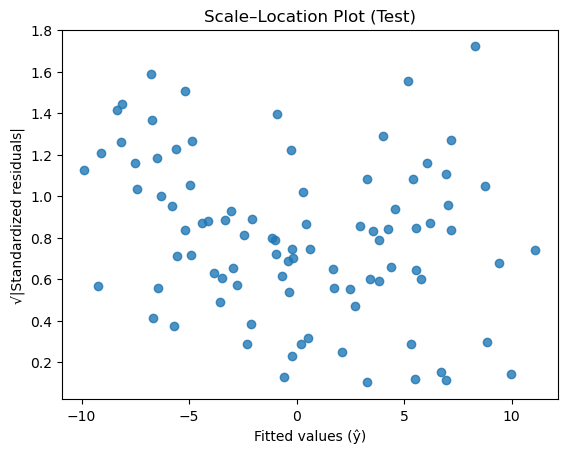

In [18]:
# ---------- 8) Scale–Location (Test) ----------
"""
**Plot name:** Scale–Location Plot
- **X-axis:** Fitted values ŷ (test)
- **Y-axis:** √|standardized residuals|
- **When useful:** Check homoscedasticity (constant variance across fit).
- **Conditions/Caveats:** Horizontal band indicates homoscedasticity; trend/funnel implies variance change.
"""
resid_std = resid_test / np.std(resid_test, ddof=1)
sqrt_abs_resid = np.sqrt(np.abs(resid_std))
fig8, ax8 = plt.subplots()
ax8.scatter(y_pred_test, sqrt_abs_resid, alpha=0.8)
ax8.set_xlabel("Fitted values (ŷ)")
ax8.set_ylabel("√|Standardized residuals|")
ax8.set_title("Scale–Location Plot (Test)")

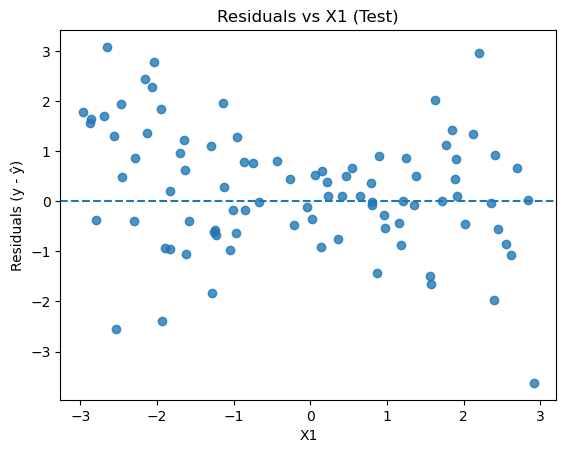

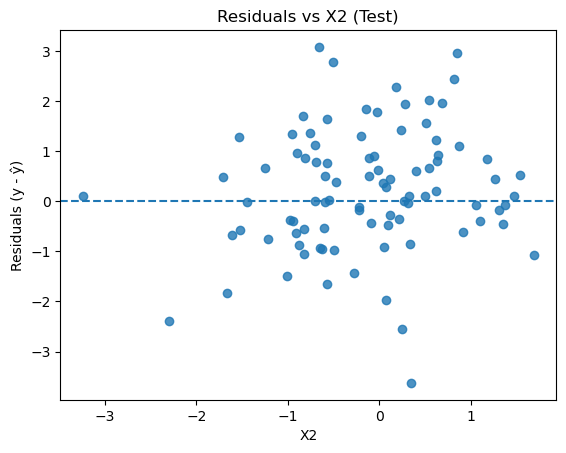

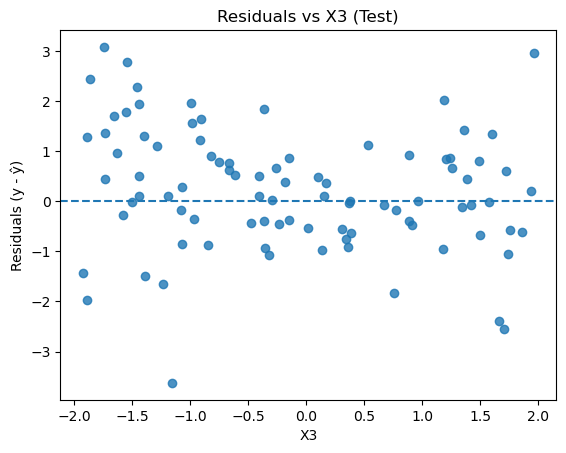

In [19]:
# ---------- 9) Residuals vs Each Predictor (Test) ----------
"""
**Plot name:** Residuals vs Predictor
- **X-axis:** Predictor value (Xj)
- **Y-axis:** Residuals (y - ŷ)
- **When useful:** Detect feature-specific nonlinearity or interactions.
- **Conditions/Caveats:** Curves/patterns → consider transformations or richer models.
"""
feature_names = ["X1", "X2", "X3"]
for j in range(X_test.shape[1]):
    fig, ax = plt.subplots()
    ax.scatter(X_test[:, j], resid_test, alpha=0.8)
    ax.axhline(0.0, linestyle="--", linewidth=1.5)
    ax.set_xlabel(feature_names[j])
    ax.set_ylabel("Residuals (y - ŷ)")
    ax.set_title(f"Residuals vs {feature_names[j]} (Test)")
    fname = f"09_residuals_vs_{feature_names[j].lower()}.png"